# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from grouping import Grouping, Resource
import plotter

# Data Input and Cleaning

## PCBC

In [2]:
# we will run some heterogeneity calculations on the pcbc data in this notebook
FILE_LOC = '../data/ptfi_1/'
FILE_NAME = 'DP_block_grade estimates_actual tons_dp coordinate.xlsx'

GIF_SAVE_LOC = '../outputs/gifs/'

draw_tons = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Drawn Tons')
cu_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Cu_PCBC')
au_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Au_PCBC')
dp_coords = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='DP_Coordinates')

draw_tons.replace(0, np.nan, inplace=True)

In [3]:
names = {
    'Draw Point Name': 'name'
}

cols = list(draw_tons.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
draw_tons = draw_tons.rename(
    columns = names
)

draw_tons = draw_tons.set_index('name').astype(float)

In [4]:
names = {
    'Draw Point Name': 'name',
    44835: '2022_10'
}

cols = list(cu_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
cu_pcbc = cu_pcbc.rename(
    columns = names
)

cu_pcbc = cu_pcbc.set_index('name').astype(float)

In [5]:
names = {
    'Draw Point Name': 'name'
}

cols = list(au_pcbc.columns)
for col_name in cols:
    if isinstance(col_name, dt.datetime):
        names[col_name] = f'{col_name.year}_{col_name.month}'
        
au_pcbc = au_pcbc.rename(
    columns = names
)

au_pcbc = au_pcbc.set_index('name').astype(float)

In [6]:
dp_coords = dp_coords.rename(
    columns={
        "Draw Point Name": "name", 
        "X-dpt": "x",
        'Y-dpt': 'y',
        'Z-dpt': 'z'
    }
)
dp_coords = dp_coords.set_index('name')

## DP Assays

In [7]:
# We will analyse the renamed "dmlz_assay" csv file in this notebook

assay = pd.read_csv("../data/ptfi_1/dmlz_assay.csv")
assay['Tons_Sampling'] = assay['Tons_Sampling'].astype(float)

rename_cols = list(assay.columns)[7:-1]
for col in rename_cols:
    assay = assay.rename(columns={col: col.split('_')[0].upper()})

# Grouping

## PCBC

In [8]:
months = list(draw_tons.columns)
dhids = list(draw_tons.index)

pcbc_groups = {}

for dhid in dhids:
    weights = draw_tons.loc[dhid]
    if weights.isnull().all():
        print(f"No data for {dhid}")
    else:
        pcbc_groups[dhid] = Grouping(dhid)
        # Add CU
        pcbc_groups[dhid].add_resource("CU", weights, cu_pcbc.loc[dhid])
        # Add AU
        pcbc_groups[dhid].add_resource("AU", weights, au_pcbc.loc[dhid])

No data for P04-11W
No data for P04-12W
No data for P04-13W
No data for P04-14W
No data for P04-15W
No data for P05-08W
No data for P05-09W
No data for P05-10W
No data for P05-11E
No data for P05-11W
No data for P05-12E
No data for P05-12W
No data for P05-13E
No data for P05-13W
No data for P05-14E
No data for P05-14W
No data for P05-15E
No data for P05-15W
No data for P05-16W
No data for P05-17W
No data for P05-18W
No data for P05-19W
No data for P05-20W
No data for P06-07W
No data for P06-08E
No data for P06-08W
No data for P06-09E
No data for P06-09W
No data for P06-10E
No data for P06-10W
No data for P06-11E
No data for P06-11W
No data for P06-12E
No data for P06-12W
No data for P06-13E
No data for P06-13W
No data for P06-14E
No data for P06-14W
No data for P06-15E
No data for P06-15W
No data for P06-16E
No data for P06-16W
No data for P06-17E
No data for P06-17W
No data for P06-18E
No data for P06-18W
No data for P06-19E
No data for P06-19W
No data for P06-20E
No data for P06-20W


## DP Assays

In [9]:
dp_groups, elements = {}, ['CU', 'AU']
dhids = assay['HOLEID'].unique()

for dhid in dhids:
    data = assay.query('HOLEID == @dhid')
    
    weights = data['SampleWeight']
    if weights.isnull().all():
        print(f"No data for {dhid}")
    else:
        dp_groups[dhid] = Grouping(dhid)
        for element in elements:
            dp_groups[dhid].add_resource(element, weights, data[element])

# Output

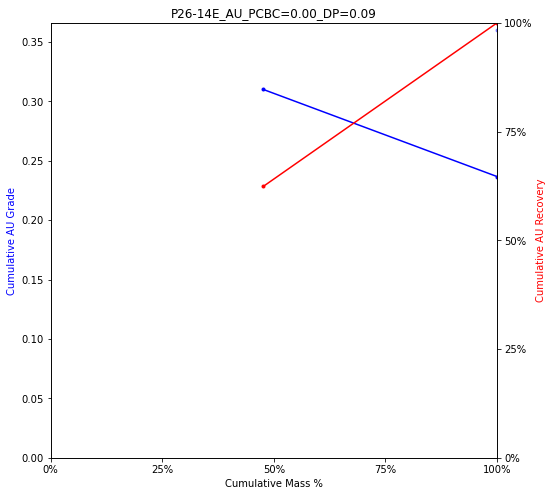

In [10]:
output_dir = "../outputs/het_analysis_compare_dp_pcbc/"

fig = plt.figure()
fig.set_size_inches(8, 8)


for dhid, pcbc_group in pcbc_groups.items():
    save_loc = output_dir + f'{dhid}/'
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)

    for element in ['CU', 'AU']:
        if element in pcbc_group.resources:
            fig.clear()
            ax = fig.add_subplot()
            ax_sec = ax.twinx()

            pcbc_het = pcbc_group.resources[element].heterogeneity
            dp_het = dp_groups[dhid].resources[element].heterogeneity
            pcbc_df = pcbc_group.resources[element].info
            dp_df = dp_groups[dhid].resources[element].info
            
            if len(pcbc_df) > 0:
                title = f'{dhid}_{element}_PCBC={pcbc_het:.2f}_DP={dp_het:.2f}'
                
                ax.set_title(title)
                plotter.plot_g_r(ax, ax_sec, pcbc_df, alpha=0.2)
                plotter.scatter_g_r(ax, ax_sec, pcbc_df, marker='.', alpha=0.4)
                plotter.plot_g_r(ax, ax_sec, dp_df)
                plotter.scatter_g_r(ax, ax_sec, dp_df, marker='.')
                
                plotter.set_g_r_labels(ax, ax_sec, element)

                fig.savefig(save_loc + title + '.svg', format='svg')

# Visualize

In [11]:
# Check if there is data not in the other group
for dpid in dp_groups:
    if dpid not in pcbc_groups:
        print(dpid)
for dpid in pcbc_groups:
    if dpid not in dp_groups:
        print(dpid)

In [17]:
delta_hs = {}

for dpid in list(dp_coords.index):
    if dpid not in dp_groups:
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
            delta_hs[element].append(np.nan)
    else:
        dp, pcbc = dp_groups[dpid], pcbc_groups[dpid]
        
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
                
            if element in dp.resources:
                dp_h, pcbc_h = dp.resources[element].heterogeneity, pcbc.resources[element].heterogeneity
                delta_hs[element].append(dp_h - pcbc_h)
            else:
                delta_hs[element].append(np.nan)

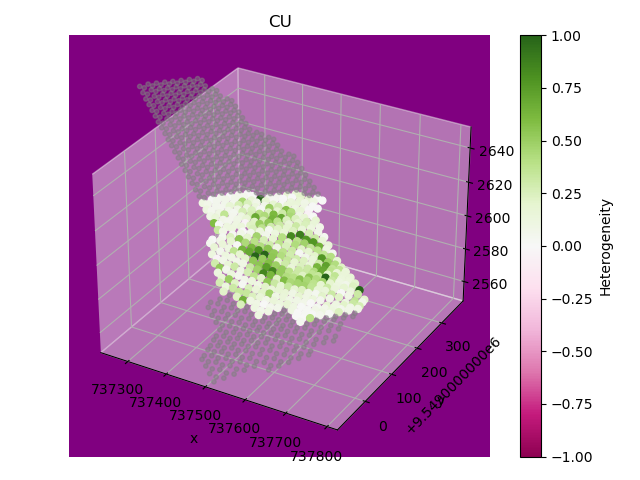

In [18]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

delta_h = np.array(delta_hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('PiYG')

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=delta_h,
    vmax=1,
    vmin=-1,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(delta_h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor('purple')

cbar = fig.colorbar(p)
cbar.set_label('Heterogeneity')

fig.tight_layout()

In [14]:
delta_hs = {}

for dpid in list(dp_coords.index):
    if dpid not in dp_groups:
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
            delta_hs[element].append(np.nan)
    else:
        dp, pcbc = dp_groups[dpid], pcbc_groups[dpid]
        
        for element in elements:
            if element not in delta_hs:
                delta_hs[element] = []
                
            if element in dp.resources:
                dp_h, pcbc_h = dp.resources[element].heterogeneity, pcbc.resources[element].heterogeneity
                if pcbc_h == 0.0:
                    delta = 1 if dp_h == 0.0 else 0
                else:
                    delta = dp_h / pcbc_h
                    
                delta_hs[element].append(delta)
            else:
                delta_hs[element].append(np.nan)

/var/folders/_x/r7wxfm355p1dqy5lc636rn240000gn/T/ipykernel_95643/449815562.py:16: RuntimeWarning: divide by zero encountered in log
  c=np.log(delta_h),


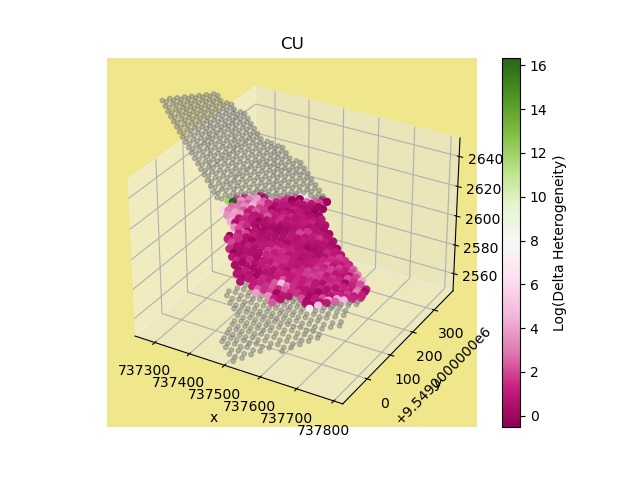

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

delta_h = np.array(delta_hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('PiYG')
ax.set_facecolor('khaki')

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=np.log(delta_h),
    # norm=colors.LogNorm(vmin=1e-1, vmax=1e1),
    cmap=cmap,
    s=25,
    alpha=1
)
# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(delta_h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

cbar = fig.colorbar(p)
cbar.set_label('Log(Delta Heterogeneity)')